In [23]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from transformers import create_optimizer

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
df = pd.read_csv('data/final.zip')
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,TOXIC,...,word_counts,unique_word_counts,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,...,43,41,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,...,17,17,daww he matches this background colour i am se...,"['daww', 'he', 'matches', 'this', 'background'...","['daww', 'matches', 'background', 'colour', 's...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'NN'), ('matches', 'NNS'), ('backgro...","['daww', 'match', 'background', 'colour', 'see...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'matches'), ('matches', 'background'..."
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,...,42,39,hey man i am really not trying to edit war it ...,"['hey', 'man', 'i', 'am', 'really', 'not', 'tr...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'realli', 'tri', 'edit', 'war',...","[('hey', 'NN'), ('man', 'NN'), ('really', 'RB'...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'really', 'try', 'edit', 'war',...","[('hey', 'man'), ('man', 'really'), ('really',..."
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,...,113,82,more i cannot make any real suggestions on im...,"['more', 'i', 'can', 'not', 'make', 'any', 're...","['make', 'real', 'suggestions', 'improvement',...","['make', 'real', 'suggest', 'improv', 'wonder'...","[('make', 'VB'), ('real', 'JJ'), ('suggestions...","['make', 'real', 'suggestion', 'improvement', ...","['make', 'real', 'suggestion', 'improvement', ...","[('make', 'real'), ('real', 'suggestions'), ('..."
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,...,13,13,you sir are my hero any chance you remember wh...,"['you', 'sir', 'are', 'my', 'hero', 'any', 'ch...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chanc', 'rememb', 'page']","[('sir', 'NN'), ('hero', 'NN'), ('chance', 'NN...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chance', 'remember', 'page']","[('sir', 'hero'), ('hero', 'chance'), ('chance..."


In [30]:
df['clean_text'] = df['clean_text'].apply(lambda x: str(x).rstrip())

# Binary Task (toxic vs no_toxic)

In [11]:
#https://tfhub.dev/google/collections/bert/1

#Input Layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

#Preprocessing Layer
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)

#Encoder Layer
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2", trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)

#Classification Layers
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(50, activation='relu')(net)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

model = tf.keras.Model(inputs=[text_input], outputs=[net])

In [19]:
text_test = [df.clean_text[0]]
text_preprocessed = preprocessing_layer(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [[  101  7526  2339  1996 10086  2015  2081  2104  2026  5310 18442 13076
  12392  2050  5470  2020 16407  2027  2020  2025  3158  9305 22556  2074
   8503  2006  2070  3806  2044  1045  5444  2012  2047  2259 14421  6904
   2278  1998  3531  2079  2025  6366  1996 23561  2013  1996  2831  3931
   2144  1045  2572  3394  2085   102     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 

In [21]:
bert_results = encoder(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"]}')

Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[[-0.9998054   0.06914964 -0.9957694   0.6163255  -0.9938086   0.9352441
  -0.97151494  0.85577315  0.06584658  0.1345311  -0.79640377 -0.04678226
   0.10051055  0.99395156  0.38214466 -0.8476348   0.9910549   0.03997683
  -0.68362445  0.9549043   0.60204387  0.02319815  0.88109475 -0.1750285
  -0.999985    0.04457276 -0.9885033   0.98921967  0.9868171   0.04439913
   0.10091305  0.06540146 -0.9893608  -0.93263024  0.46841612  0.99760175
  -0.8529614  -0.00429865 -0.12378181 -0.9813784   0.9413834   0.9587755
  -0.99263495  0.923328   -0.863254   -0.2314541  -0.9921904   0.99281424
   0.73514634  0.99877816  0.9548455  -0.95171887  0.07241374  0.9926621
   0.9509622   0.6819752  -0.47093508 -0.10977381  0.7396386  -0.8638437
   0.11524896  0.29072836 -0.0780286   0.9568176  -0.12766619 -0.9968939
   0.80258715  0.8487483   0.71616995  0.93155074  0.99905974 -0.06146409
  -0.9930612   0.1900095   0.7594273  -0.9935487  -0.38415343  0.0

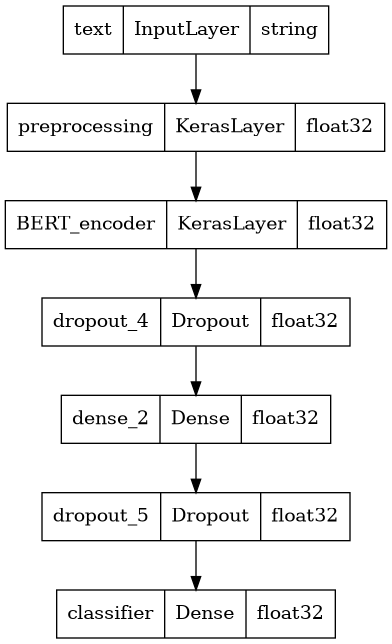

In [22]:
tf.keras.utils.plot_model(model, show_dtype=True)

In [144]:
X = df.clean_text
y = df['TOXIC']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
batch_size = 64
epochs  = 4
batches_per_epoch = len(X_train) // batch_size
total_train_steps = int(batches_per_epoch * epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='acc')

In [147]:
batches_per_epoch, total_train_steps

(2794, 11176)

In [149]:
history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),  #Va cambiato con validation_split=0.1
                       epochs=epochs)

Epoch 1/4
5589/5589 [==============================] - 365s 65ms/step - loss: 0.1614 - acc: 0.9463 - val_loss: 0.1315 - val_acc: 0.9529
Epoch 2/4
5589/5589 [==============================] - 361s 65ms/step - loss: 0.1375 - acc: 0.9504 - val_loss: 0.1269 - val_acc: 0.9535
Epoch 3/4
5589/5589 [==============================] - 363s 65ms/step - loss: 0.1352 - acc: 0.9509 - val_loss: 0.1269 - val_acc: 0.9535
Epoch 4/4
5589/5589 [==============================] - 363s 65ms/step - loss: 0.1348 - acc: 0.9510 - val_loss: 0.1269 - val_acc: 0.9535


In [150]:
history.history

{'loss': [0.16135714948177338,
  0.13753026723861694,
  0.13515250384807587,
  0.13482336699962616],
 'acc': [0.9462589025497437,
  0.9503520131111145,
  0.9509335160255432,
  0.9510397911071777],
 'val_loss': [0.13152329623699188,
  0.1268678605556488,
  0.1268678605556488,
  0.1268678605556488],
 'val_acc': [0.9528740644454956,
  0.9535003304481506,
  0.9535003304481506,
  0.9535003304481506]}

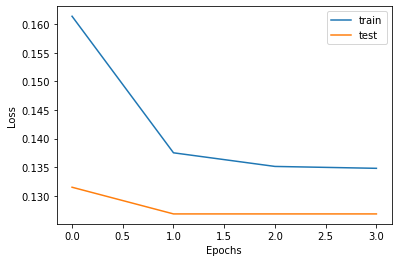

In [151]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

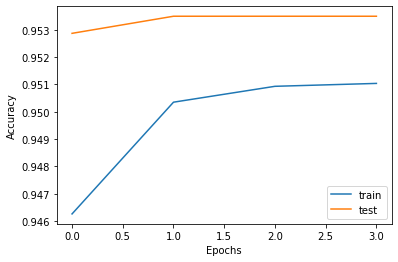

In [152]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [153]:
predictions = model.predict(X_val)

In [154]:
y_pred = np.round(predictions)

In [155]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     40225
           1       0.79      0.73      0.76      4485

    accuracy                           0.95     44710
   macro avg       0.88      0.86      0.87     44710
weighted avg       0.95      0.95      0.95     44710



# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate

In [51]:
#Input Layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

#Preprocessing Layer
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)

#Encoder Layer
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2", trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)

#Classification Layers
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(50, activation='relu')(net)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)

model = tf.keras.Model(inputs=[text_input], outputs=[net])

In [52]:
batch_size = 64
epochs  = 4
batches_per_epoch = len(X_train) // batch_size
total_train_steps = int(batches_per_epoch * epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='acc')

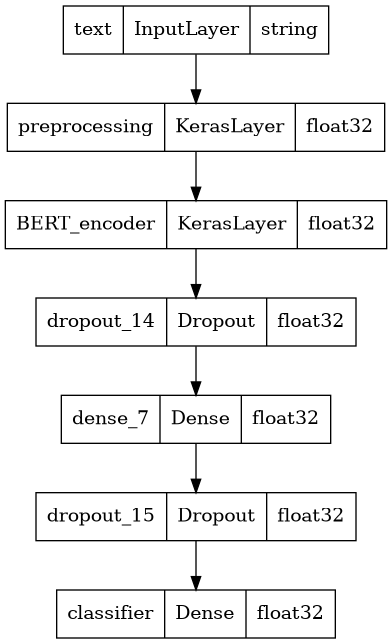

In [53]:
tf.keras.utils.plot_model(model, show_dtype=True)

In [54]:
X = df.clean_text
y = df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),   #Va cambiato con validation_split=0.1
                       epochs=epochs)

Epoch 1/4
5589/5589 [==============================] - 557s 99ms/step - loss: 0.1614 - acc: 0.5662 - val_loss: 0.0844 - val_acc: 0.9951
Epoch 2/4
5589/5589 [==============================] - 552s 99ms/step - loss: 0.0811 - acc: 0.5683 - val_loss: 0.0699 - val_acc: 0.9951
Epoch 3/4
5589/5589 [==============================] - 558s 100ms/step - loss: 0.0754 - acc: 0.5945 - val_loss: 0.0699 - val_acc: 0.9951
Epoch 4/4
5589/5589 [==============================] - 549s 98ms/step - loss: 0.0755 - acc: 0.5953 - val_loss: 0.0699 - val_acc: 0.9951


In [56]:
history.history

{'loss': [0.16136153042316437,
  0.08105543255805969,
  0.07541345059871674,
  0.07551664859056473],
 'acc': [0.5662411451339722,
  0.5683379769325256,
  0.5945291519165039,
  0.5953455567359924],
 'val_loss': [0.08443357795476913,
  0.06993142515420914,
  0.06993142515420914,
  0.06993142515420914],
 'val_acc': [0.9951017498970032,
  0.9951017498970032,
  0.9951017498970032,
  0.9951017498970032]}

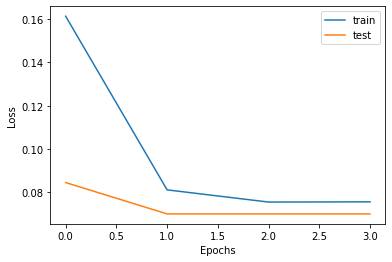

In [57]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

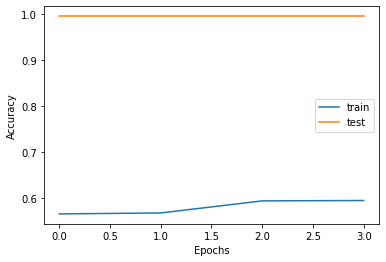

In [58]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
predictions = model.predict(X_val)
y_pred = np.round(predictions)

In [60]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75      4266
           1       1.00      0.01      0.02       384
           2       0.77      0.77      0.77      2486
           3       0.00      0.00      0.00       133
           4       0.69      0.67      0.68      2294
           5       0.00      0.00      0.00       408

   micro avg       0.75      0.66      0.70      9971
   macro avg       0.54      0.36      0.37      9971
weighted avg       0.72      0.66      0.67      9971
 samples avg       0.06      0.06      0.06      9971



---

# transformers library (tf) ----- Test!!!!!

In [19]:
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

ModuleNotFoundError: No module named 'transformers'

In [7]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [8]:
tokenizer(df.comment_text[0])

{'input_ids': [101, 7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 1029, 2027, 4694, 1005, 1056, 3158, 9305, 22556, 1010, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 2278, 1012, 1998, 3531, 2123, 1005, 1056, 6366, 1996, 23561, 2013, 1996, 2831, 3931, 2144, 1045, 1005, 1049, 3394, 2085, 1012, 6486, 1012, 16327, 1012, 4229, 1012, 2676, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [10]:
from sklearn.model_selection import train_test_split

X = df.comment_text.sample(frac = 0.1, random_state=42)
y = df['class'][X.index]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#tokenize the text
X_train_enc = tokenizer(list(X_train), truncation=True, padding=True)
X_val_enc = tokenizer(list(X_val), truncation=True, padding=True)

In [11]:
print(f'Text: { X_train[:1] }')
print(f'Input ids: { X_train_enc["input_ids"][0] } ')
print(f'Input ids: { X_train_enc["attention_mask"][0] } ')

Text: 106369    RU and RL\nSince there is no hybridized rules ...
Name: comment_text, dtype: object
Input ids: [101, 21766, 1998, 1054, 2140, 2144, 2045, 2003, 2053, 8893, 3550, 3513, 2003, 2023, 2428, 1037, 8893, 1029, 1045, 2812, 2182, 1999, 3163, 2057, 2070, 2051, 2156, 2028, 2431, 4715, 1998, 2028, 2431, 11196, 2374, 2021, 2169, 2431, 2003, 2209, 1999, 1996, 6687, 9537, 3513, 1012, 2005, 21766, 1998, 1054, 2140, 2003, 2037, 2151, 2742, 1997, 2399, 2108, 2209, 2005, 2742, 2007, 2240, 21100, 2021, 2069, 1019, 10455, 1029, 6564, 1012, 4413, 1012, 6535, 1012, 16333, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices( (dict(X_train_enc), list(y_train)) )
val_dataset = tf.data.Dataset.from_tensor_slices( (dict(X_val_enc), list(y_val)) )
train_dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [17]:
from transformers import create_optimizer

batch_size = 8
epochs  = 4
batches_per_epoch = len(X_train) // batch_size
total_train_steps = int(batches_per_epoch * epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='acc')

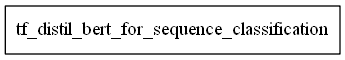

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [25]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(train_dataset.batch(batch_size),
                       validation_data=val_dataset,
                       epochs=epochs)

Epoch 1/4


ResourceExhaustedError:  OOM when allocating tensor with shape[8,12,512,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node tf_distil_bert_for_sequence_classification/distilbert/transformer/layer_._3/attention/transpose_1
 (defined at C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py:179)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_23435]

Errors may have originated from an input operation.
Input Source operations connected to node tf_distil_bert_for_sequence_classification/distilbert/transformer/layer_._3/attention/transpose_1:
In[0] tf_distil_bert_for_sequence_classification/distilbert/transformer/layer_._3/attention/Reshape_1:	
In[1] tf_distil_bert_for_sequence_classification/distilbert/transformer/layer_._3/attention/transpose_1/perm:

Operation defined at: (most recent call last)
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\FRANCE~1\AppData\Local\Temp/ipykernel_2852/2952165569.py", line 1, in <module>
>>>     history = model.fit(train_dataset.batch(batch_size),
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\modeling_tf_utils.py", line 796, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 800, in call
>>>     distilbert_output = self.distilbert(
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 418, in call
>>>     tfmr_output = self.transformer(
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 314, in call
>>>     for i, layer_module in enumerate(self.layer):
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 318, in call
>>>     layer_outputs = layer_module(hidden_state, attn_mask, head_mask[i], output_attentions, training=training)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 266, in call
>>>     sa_output = self.attention(x, x, x, attn_mask, head_mask, output_attentions, training=training)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 186, in call
>>>     k = shape(self.k_lin(key))  # (bs, n_heads, k_length, dim_per_head)
>>> 
>>>   File "C:\Users\Francesco\anaconda3\envs\ta\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 179, in shape
>>>     return tf.transpose(tf.reshape(x, (bs, -1, self.n_heads, dim_per_head)), perm=(0, 2, 1, 3))
>>> 